In [ ]:
import numpy as np
import pandas as pd
import scipy.stats as st
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import bootstrap
import pandahouse as ph

In [ ]:
connection = {
    'host': 'https://clickhouse.lab.karpov.courses',
    'password': 'dpo_python_2020',
    'user': 'student',
    'database': 'simulator'
}


In [ ]:
q = """
SELECT exp_group, 
    user_id,
    sum(action = 'like') as likes,
    sum(action = 'view') as views,
    likes/views as ctr
FROM simulator_20231113.feed_actions  
WHERE toDate(time) between '2023-10-18' and '2023-10-24'
    and exp_group in (2,3)
GROUP BY exp_group, user_id
"""

df = ph.read_clickhouse(q, connection=connection)

df.groupby('exp_group').count()

,user_id,likes,views,ctr
exp_group,,,,
2,8362,8362,8362,8362
3,8425,8425,8425,8425


In [ ]:
df

,exp_group,user_id,likes,views,ctr
0,3,115383,38,248,0.153226
1,3,10326,24,132,0.181818
2,3,123580,25,122,0.204918
3,2,131473,19,98,0.193878
4,2,23985,12,44,0.272727
...,...,...,...,...,...
16782,3,122008,20,123,0.162602
16783,2,25383,2,18,0.111111
16784,3,122190,15,56,0.267857
16785,2,108927,16,51,0.313725


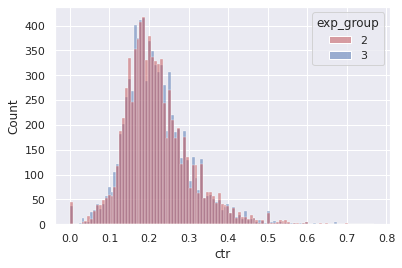

In [ ]:
# Сделаем графики в seaborn покрупнее
sns.set(rc={'figure.figsize':(11.7,8.27)})

groups = sns.histplot(data = df, 
              x='ctr', 
              hue='exp_group', 
              palette = ['r', 'b'],
              alpha=0.5,
              kde=False)

In [ ]:
#и t-тест тоже

st.ttest_ind(df[df.exp_group == 2].ctr,
                df[df.exp_group == 3].ctr,
                equal_var=False)

Ttest_indResult(statistic=0.6617303509169986, pvalue=0.508153138292614)

In [ ]:
# Создаем пустой список для хранения p-values
p_values = []
 
# Цикл для 10000 симуляций
for _ in range(10000):
    # Формируем подвыборки
    sample_2 = df[df['exp_group'] == 2].sample(500)
    sample_3 = df[df['exp_group'] == 3].sample(500)
 
    # Выполняем t-тест
    _, p_value = st.ttest_ind(sample_2['ctr'], sample_3['ctr'], equal_var=False)
    p_values.append(p_value)
 
#Анализируем результаты
p_values = np.array(p_values)
percentage_under_005 = np.mean(p_values <= 0.05) * 100
 
# Вывод результатов
print(f"Процент p-values <= 0.05: {percentage_under_005}%")

Процент p-values <= 0.05: 4.81%


In [6]:
df = pd.DataFrame(p_values, columns=['p_value'])

<Axes: >

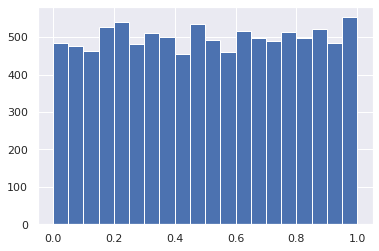

In [7]:
df.p_value.hist(bins = 20)

## Вывод: 
После проведенного мной теста можно увидеть, что у нас в 4.81% случаев получались статистические значимые различия между 2 и 3 группой (p_value < 0.05). Поэтому система сплитования работает корректно, Это особенно хорошо видно на графике `df.p_value.hist(bins = 20)` распределении p-value, которое равномерно